## Customer segmentation

Think: “Let me group customers by behavior.”

Use RFM (Recency, Frequency, Monetary) analysis.

Recency: how recently they purchased.

Frequency: how often they purchase.

Monetary: how much money they spend.

Cluster customers using KMeans.

Visualize segments (loyal customers, big spenders, etc.).

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Forecasting
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Robust date parsing
from dateutil import parser

# Inline plots
%matplotlib inline

## Load clean dataset

start segmentation with cleaned, identical data

In [2]:
#Load Dataset

# Load CSV
data = pd.read_csv("../data/OnlineRetailDataSet.csv", encoding='utf-8-sig')

# Quick overview

print(data.head())
print(data.info())
print("Number of unique customers:", data['CustomerID'].nunique())
print("Number of unique invoices:", data['InvoiceNo'].nunique())
print("Number of unique products:", data['Description'].nunique())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  1/12/2010 8:26       2.55     17850.0  United Kingdom  
1  1/12/2010 8:26       3.39     17850.0  United Kingdom  
2  1/12/2010 8:26       2.75     17850.0  United Kingdom  
3  1/12/2010 8:26       3.39     17850.0  United Kingdom  
4  1/12/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

## Data Cleaning


In [66]:


# Convert InvoiceDate to datetime safely
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True, errors='coerce')

# Drop invalid dates
data = data.dropna(subset=['InvoiceDate'])

# Remove cancelled orders (InvoiceNo starting with 'C')
data = data[~data['InvoiceNo'].str.startswith('C')]

# Drop rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])

# Add TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']



# Check shape
data.shape

(168649, 9)

In [69]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Customer Aggregation


In [72]:
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'TotalPrice':'Monetary'
})

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,5,2540.29
12348.0,249,1,367.00
12350.0,310,1,334.40
12352.0,36,3,1296.38
12355.0,214,1,459.40


## Check and visualize RFM distributions

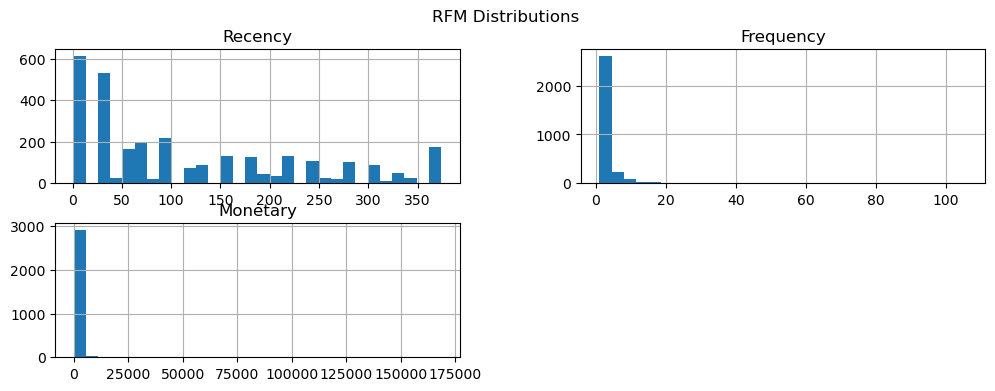

In [73]:
# Histograms
rfm[['Recency','Frequency','Monetary']].hist(bins=30, figsize=(12,4))
plt.suptitle("RFM Distributions")
plt.show()

# Optional: log-transform Monetary if highly skewed
import numpy as np
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])


## Scale the RFM features(KMeans)


In [74]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])


## Choose number of clusters

Elbow Method or Silhouette Score to pick k

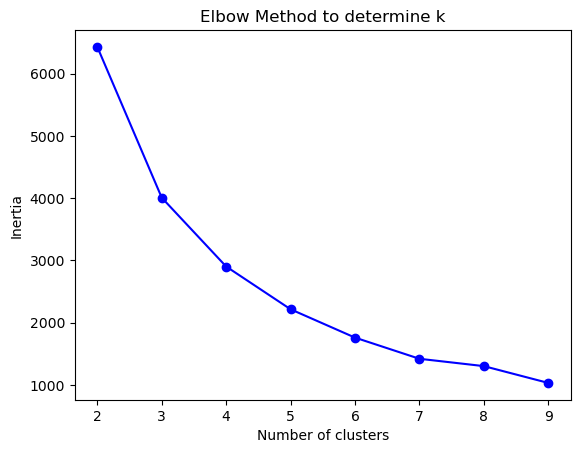

In [75]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to determine k')
plt.show()


## Apply KMeans clustering

Adds a Cluster column to the RFM table

In [76]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


## Analyze cluster profiles

Cluster summary

In [77]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}).round(1)

print(cluster_summary)


        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          46.8       2.8    1092.3  1903
1         258.4       1.3     473.7  1042
2           1.3      19.3  130680.0     3
3          19.9      22.5   18595.2    49


## Cluster Analysis & 7Ps Insights



| Cluster | Behavior Type                                                                                    | Insights (7Ps)                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ------- | ------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | Moderate Recency (46.8), Low Frequency (2.8), Moderate Monetary (1092)                           | **Product:** Offer popular or mid-range products. <br> **Price:** Standard pricing or small promotions. <br> **Place:** Target countries with more customers from EDA. <br> **Promotion:** Remind via email campaigns to increase frequency. <br> **People:** Focus on customer service to engage more. <br> **Process:** Encourage repeat orders via loyalty programs. <br> **Physical Evidence:** Highlight product quality in website/packaging. |
| **1**   | High Recency (258.4 = haven’t purchased in a long time), Low Frequency (1.3), Low Monetary (473) | **Product:** Affordable products to attract back. <br> **Price:** Offer discounts or promotions to re-engage. <br> **Place:** Focus campaigns in regions where they are located. <br> **Promotion:** Re-engagement emails, special offers. <br> **People:** Personalized outreach to win them back. <br> **Process:** Easy purchase flow and reminders. <br> **Physical Evidence:** Use trust signals, reviews, testimonials.                       |
| **2**   | Very Recent (1.3), Very High Frequency (19.3), Extremely High Monetary (130,680)                 | **Product:** Premium products, bundles, exclusive offers. <br> **Price:** Loyalty pricing, reward programs. <br> **Place:** High-value customers may be global/top countries. <br> **Promotion:** Exclusive campaigns, VIP offers. <br> **People:** Personalized account managers or service. <br> **Process:** Smooth ordering, quick delivery. <br> **Physical Evidence:** Showcase premium quality, branding.                                    |
| **3**   | Recent (19.9), Very High Frequency (22.5), High Monetary (18,595)                                | **Product:** High-value products or bundles. <br> **Price:** Offer loyalty discounts or incentives. <br> **Place:** Focus on key regions. <br> **Promotion:** Targeted campaigns for top buyers. <br> **People:** Personalized communication. <br> **Process:** Ensure quick service and support. <br> **Physical Evidence:** Emphasize product quality and exclusivity.                                                                            |


## Visualize clusters

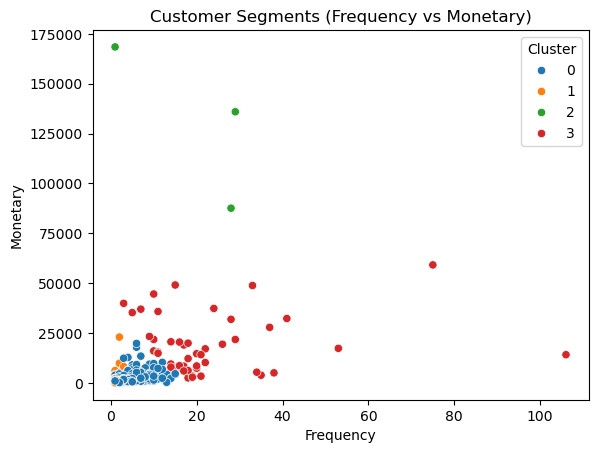

In [78]:
import seaborn as sns

sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Customer Segments (Frequency vs Monetary)")
plt.savefig("../visuals/rfm_clusters.png", dpi=150)
plt.show()
